In [153]:
"""Temporary fix for importing modules from parent directory"""

import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [154]:
"""
Copyright (C) 2022 LAAS-CNRS, INRIA

Author:
    Wilson Jallet
"""

import proxsuite_nlp

import pinocchio as pin

from darli.backend import CasadiBackend
from darli.modeling.functional import Functional
from varitop.integrator import DelIntegrator as DI
from varitop.misc import euler_rule, skew_quaternion, qconj, q2rm

import numpy as np
import casadi as cas

import example_robot_data as erd
import matplotlib.pyplot as plt

from proxsuite_nlp.manifolds import MultibodyPhaseSpace, VectorSpace
from proxsuite_nlp.utils import plot_pd_errs
from proxsuite_nlp.casadi_utils import CasadiFunction

In [155]:
urdf_path = "../assets/urdf/skydio_x2.urdf"

In [156]:
print("Package version: {}".format(proxsuite_nlp.__version__))
# robot = erd.load("double_pendulum")
model = pin.buildModelFromUrdf(urdf_path)
rdata = model.createData()

Package version: 0.4.0


In [157]:
darli_model = Functional(CasadiBackend(urdf_path))
darli_model.nq, darli_model.nv, darli_model.nu

(7, 6, 6)

In [158]:
Tf = 1.2
dt = 1.0 / 30
nsteps = int(Tf / dt)
Tf = nsteps * dt
print("Time horizon: {:.3g}".format(Tf))
print("Time step   : {:.3g}".format(dt))
print("No. of steps: {:d}".format(nsteps))

nq = model.nq
nu = darli_model.nu

Time horizon: 1.2
Time step   : 0.0333
No. of steps: 36


In [159]:
print(xspace.nx + nu)

19


In [160]:
xspace = MultibodyPhaseSpace(model)
pb_space = VectorSpace(nsteps * nu + (nsteps + 1) * (xspace.nx))

u_bound = 1000
x0 = xspace.neutral()
# theta0 = np.pi / 3
# x0[3] = np.sin(theta0 / 2)
# x0[6] = np.cos(theta0 / 2)
xtarget = xspace.neutral()
print("Initial:", x0)
print("Final  :", xtarget)

Initial: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Final  : [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [161]:
def make_dynamics_expression(x0, cxs, cus):
    resdls = [cxs[0] - x0, cxs[1] - x0]

    for t in range(2, nsteps):
        x0 = cxs[t - 2][:nq]
        x1 = cxs[t - 1][:nq]
        x2 = cxs[t - 0][:nq]
        v2 = cxs[t - 0][nq:]
        u2 = cus[t - 0]

        K = cas.vcat(
            [
                cas.hcat([-0.18, 0.18, 0.18, -0.18]),
                cas.hcat([0.14, 0.14, -0.14, -0.14]),
                cas.hcat([-0.0201, 0.0201, 0.0201, -0.0201]),
            ]
        )

        di = DI()
        di.nq = darli_model.nq
        di.nu = darli_model.nu
        di.quaternion_index = 3
        cq = cas.SX.sym("cq", darli_model.nq)
        cdq = cas.SX.sym("cdq", darli_model.nq)
        cu = cas.SX.sym("cu", darli_model.nu)
        F = cas.Function(
            "f",
            [cq, cdq, cu],
            [
                cas.vcat(
                    [
                        0,
                        0,
                        0,
                        2
                        * skew_quaternion(cq[3:])
                        @ cas.vertcat(0, K @ np.zeros(cu[2:].shape[0])),
                    ]
                )
            ],
        )
        cv = di.v(cq, cdq)
        di.lagrangian = cas.Function(
            "L", [cq, cdq], [darli_model.lagrangian(cq, cv)], ["q", "dq"], ["L"]
        )
        di.rule = euler_rule
        di.add_generalized_forces([F])

        sfx0 = cas.vcat([x0[:3], x0[6], x0[3:6]])
        sfx1 = cas.vcat([x1[:3], x1[6], x1[3:6]])
        sfx2 = cas.vcat([x2[:3], x2[6], x2[3:6]])

        qnext = di.get_residual()(sfx0, sfx1, sfx2, dt, u2)
        vnext = di.v(qnext, qnext - sfx2)
        xnext = cas.vertcat(qnext, vnext)
        resdls.append(cxs[t - 0] - xnext)

        # print(qnext)

        # tau = B @ cus[t]
        # acc = cpin.aba(cmodel, cdata, q, v, tau)
        # vnext = v + dt * acc
        # qnext = cpin.integrate(cmodel, q, dt * vnext)
        # xnext = cas.vertcat(qnext, vnext)
        # resdls.append(cxs[t + 1] - xnext)
    expression = cas.vertcat(*resdls)
    return expression

In [162]:
class MultipleShootingProblem:
    """Multiple-shooting formulation."""

    def __init__(self, x0, xtarget):

        cxs = [cas.SX.sym("x%i" % i, xspace.nx) for i in range(nsteps + 1)]
        cus = [cas.SX.sym("u%i" % i, nu) for i in range(nsteps)]

        cX_s = cas.vertcat(*cxs)
        cU_s = cas.vertcat(*cus)
        cXU_s = cas.vertcat(cX_s, cU_s)

        w_u = 1e-2
        w_x = 1e-3
        w_term = 2.0 * np.ones(xspace.nx)
        ferr = cxs[nsteps] - xtarget

        cost_expression = (
            0.5 * w_x * dt * cas.dot(cX_s, cX_s)
            + 0.5 * w_u * dt * cas.dot(cU_s, cU_s)
            + 0.5 * cas.dot(ferr, w_term * ferr)
        )

        # Most probably can leave as is
        self.cost_fun = CasadiFunction(
            pb_space.nx, pb_space.ndx, cost_expression, cXU_s, use_hessian=True
        )

        x0 = cas.SX(x0)
        expression = make_dynamics_expression(x0, cxs, cus)
        self.dynamics_fun = CasadiFunction(
            pb_space.nx, pb_space.ndx, expression, cXU_s, use_hessian=False
        )

        # Most probably can leave as is
        control_bounds_ = []
        for t in range(nsteps):
            control_bounds_.append(cus[t] - u_bound)
            control_bounds_.append(-cus[t] - u_bound)
        control_expr = cas.vertcat(*control_bounds_)
        self.control_bound_fun = CasadiFunction(
            pb_space.nx, pb_space.ndx, control_expr, cXU_s, use_hessian=False
        )

In [163]:
probdef = MultipleShootingProblem(x0, xtarget)

cost_fun = proxsuite_nlp.costs.CostFromFunction(probdef.cost_fun)

dynamical_constraint = proxsuite_nlp.constraints.createEqualityConstraint(
    probdef.dynamics_fun
)

bound_constraint = proxsuite_nlp.constraints.createInequalityConstraint(
    probdef.control_bound_fun
)

constraints_ = []
constraints_.append(dynamical_constraint)
constraints_.append(bound_constraint)
problem = proxsuite_nlp.Problem(pb_space, cost_fun, constraints_)

print("No. of variables  :", pb_space.nx)
print("No. of constraints:", problem.total_constraint_dim)

callback = proxsuite_nlp.helpers.HistoryCallback()

No. of variables  : 697
No. of constraints: 900


In [164]:
tol = 1e-5
rho_init = 1e-8
mu_init = 0.9
solver = proxsuite_nlp.ProxNLPSolver(
    problem, mu_init=mu_init, rho_init=rho_init, tol=tol, verbose=proxsuite_nlp.VERBOSE
)
solver.setup()
solver.register_callback(callback)
solver.max_iters = 300

xu_init = pb_space.neutral()
for t in range(nsteps + 1):
    xu_init[t * (xspace.nx + nu) : t * (xspace.nx + nu) + xspace.nx] = x0
lams0 = [np.zeros(cs.nr) for cs in constraints_]
try:
    flag = solver.solve(xu_init, lams0)
except RuntimeError:
    import pprint

    pprint.pp(callback.storage.xs.tolist())
    raise

workspace = solver.getWorkspace()
results = solver.getResults()

print(results)

iter｜step_size ｜inner_crit｜ prim_err ｜ dual_err ｜   xreg   ｜  dphi0   ｜  merit   ｜    dM    ｜ al_iter  
   1｜ 1.000e+00｜ 7.950e+01｜ 7.950e+01｜ 2.000e+00｜ 0.000e+00｜-2.057e+05｜ 3.093e+00｜ -1.03e+05｜         1
   2｜ 2.500e-01｜ 1.004e+00｜ 1.004e+00｜ 2.760e-03｜ 0.000e+00｜-6.181e+00｜ 2.006e+00｜     -1.09｜         1
   3｜ 2.500e-01｜ 7.741e-01｜ 7.741e-01｜ 2.519e-03｜ 0.000e+00｜-4.006e+00｜ 1.471e+00｜    -0.537｜         3
   4｜ 1.250e-01｜ 5.895e-01｜ 5.895e-01｜ 7.088e-03｜ 0.000e+00｜-2.931e+00｜ 1.344e+00｜     -0.13｜         6
   5｜ 6.250e-02｜ 5.182e-01｜ 5.182e-01｜ 8.549e-03｜ 0.000e+00｜-2.669e+00｜ 1.307e+00｜   -0.0401｜         7
   6｜ 6.250e-02｜ 4.860e-01｜ 4.869e-01｜ 9.572e-03｜ 0.000e+00｜-2.584e+00｜ 1.238e+00｜   -0.0689｜         7
   7｜ 1.250e-01｜ 4.575e-01｜ 4.575e-01｜ 1.062e-02｜ 0.000e+00｜-2.447e+00｜ 1.060e+00｜    -0.182｜         8
   8｜ 2.500e-01｜ 4.172e-01｜ 4.172e-01｜ 1.653e-02｜ 0.000e+00｜-2.085e+00｜ 6.815e-01｜    -0.384｜         9
   9｜ 5.000e-01｜ 3.066e-01｜ 3.066e-01｜ 4.328e-02｜ 0.000e+00｜-1.3

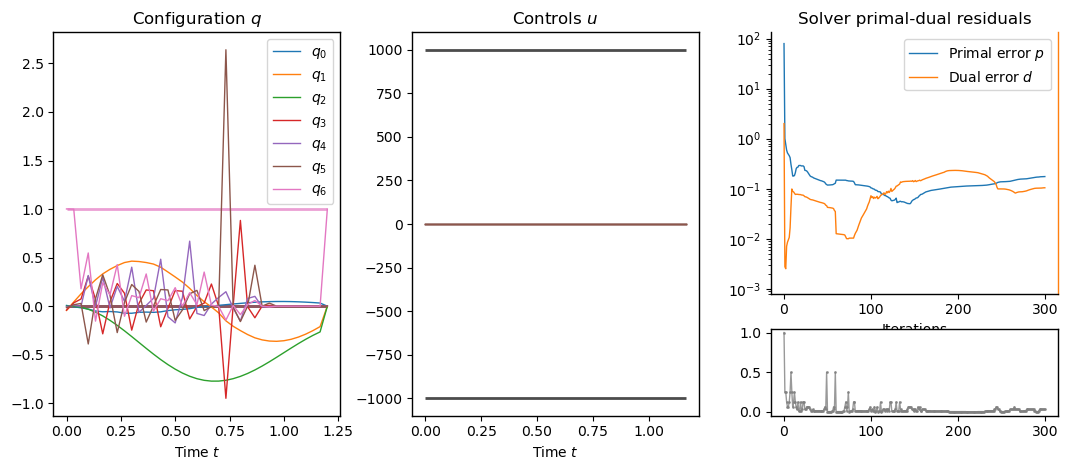

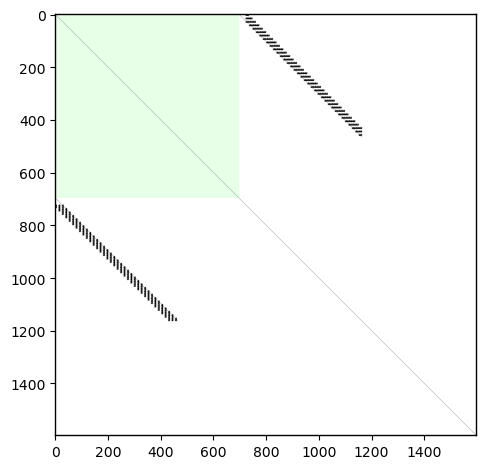

In [165]:
prim_errs = callback.storage.prim_infeas
dual_errs = callback.storage.dual_infeas

xus_opt = results.xopt
xs_opt_flat = xus_opt[: (nsteps + 1) * xspace.nx]
us_opt_flat = xus_opt[(nsteps + 1) * xspace.nx :]
us_opt = us_opt_flat.reshape(nsteps, -1)
xs_opt = xs_opt_flat.reshape(nsteps + 1, -1)
qs_opt = xs_opt[:, : model.nq]
vs_opt = xs_opt[:, model.nq :]

# Plotting

plt.rcParams["lines.linewidth"] = 1.0
plt.rcParams["axes.linewidth"] = 1.0

times = np.linspace(0.0, Tf, nsteps + 1)
labels_ = ["$x_{%i}$" % i for i in range(model.nq)]

fig: plt.Figure = plt.figure(figsize=(10.8, 4.8))
gs0 = fig.add_gridspec(1, 3)

plt.subplot(gs0[0])
hlines_style = dict(alpha=0.7, ls="-", lw=2, zorder=-1)
lines = plt.plot(times, qs_opt)
cols_ = [li.get_color() for li in lines]
labels_ = ["$q_{0}$".format(i) for i in range(model.nq)]
hlines = plt.hlines(xtarget[: model.nq], *times[[0, -1]], colors=cols_, **hlines_style)

plt.legend(labels_)
plt.xlabel("Time $t$")
plt.title("Configuration $q$")

plt.subplot(gs0[1])
plt.plot(times[:-1], us_opt)
plt.hlines((-u_bound, u_bound), *times[[0, -2]], colors="k", **hlines_style)
plt.xlabel("Time $t$")
plt.title("Controls $u$")

gss = gs0[2].subgridspec(2, 1, height_ratios=[3, 1])
ax0 = plt.subplot(gss[0])
plot_pd_errs(ax0, prim_errs, dual_errs)

plt.subplot(gss[1])
plt.plot(callback.storage.alphas, c="gray", alpha=0.8, marker=".", markersize=2)
plt.tight_layout()

# plot kkt matrix
fig, ax = plt.subplots()
kkt_mat = workspace.kkt_matrix.copy()
plt.imshow(kkt_mat.astype(bool), cmap=plt.cm.binary, vmin=0.0)
ntot = pb_space.ndx
ptch = plt.Rectangle((0, 0), ntot, ntot)
ptch.set_facecolor("#19ff1d")
ptch.set_alpha(0.1)
ptch.set_edgecolor("none")
ptch.set_transform(ax.transData)
ax.add_patch(ptch)

plt.tight_layout()
plt.show()

In [166]:
qs_sol = np.array(xs_opt[:, 3:7])
qs_sol = qs_sol[:, [3, 0, 1, 2]]

In [167]:
basis_vectors = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
rms = q2rm(qs_sol)

MovieWriter ffmpeg unavailable; using Pillow instead.


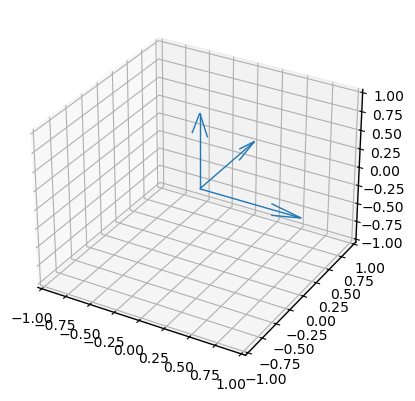

In [168]:
from matplotlib.animation import FuncAnimation

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)

basis = ax.quiver(0, 0, 0, basis_vectors[0], basis_vectors[1], basis_vectors[2])


def update(frame):
    # Rotate the basis vectors
    rotated_vectors = rms[frame] @ basis_vectors.T

    global basis
    basis.remove()
    basis = ax.quiver(
        0, 0, 0, rotated_vectors[0], rotated_vectors[1], rotated_vectors[2]
    )


# Create the animation
animation = FuncAnimation(fig, update, frames=len(qs_sol))

# Save the animation as a GIF using Pillow writer
animation.save("evolution_history_x2.gif")

# Display the animation
plt.show()